In [1]:
#Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import t

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
def create_df_response(samples, time, date_init ='2020-03-06',
                       quantiles = [50, 80, 95], forecast_horizon=27,
                       dates=None, use_future=False):
    """[summary]

    Args:
        samples ([type]): [description]
        time ([type]): [description]
        date_init (str, optional): [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """
    if dates is not None:
        dates_fitted = dates
    else:
        dates_fitted   = pd.date_range(start=pd.to_datetime(date_init),
                                       periods=time, freq='W')
        dates_forecast = pd.date_range(start=dates_fitted[-1]+timedelta(1),
                                       periods=forecast_horizon)

    dates = list(dates_fitted)
    types = ['estimate']*len(dates_fitted)
    if use_future:
        dates += list(dates_forecast)
        types  += ['forecast']*len(dates_forecast)

    results_df = pd.DataFrame(samples.T)
    df_response = pd.DataFrame(index=dates)

    df_response['mean']        = results_df.mean(axis=1).values
    df_response['median']      = results_df.median(axis=1).values
    df_response['std']         = results_df.std(axis=1).values

    for quant in quantiles:
        low_q  = ((100-quant)/2)/100
        high_q = 1-low_q

        df_response[f'low_{quant}']  = results_df.quantile(q=low_q,
                                                           axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q,
                                                           axis=1).values

    df_response['type']        =  types
    df_response.index.name = 'date'
    return df_response

In [3]:
#Import data
dataset = pd.read_csv("../Data/finaldata3.csv", parse_dates=['Date'], index_col='Date')
print(dataset.shape)
dataset.head()

(781, 17)


,Dengue,Dengue_grave,Mortalidad_por_dengue,denguedolor de cabezamigrananauseasvomitobrotefiebrehemorragia,dolor ojospicadura mosquito,sintomas dengue,dolor muscular,mosquito,mosquito dengue,dengue hemorragico,mosquitos,dolor huesos,dolor articulaciones,mean_temperature,min_temperature,max_temperature,mean_rain
Date,,,,,,,,,,,,,,,,,
2007-01-07,663.0,116.0,0.0,16.482143,24.285714,27.142857,40.142857,5.285714,0.000000,0.000000,0.000000,8.571429,28.571429,28.857133,4.69,41.43,7.507262
2007-01-14,415.0,86.0,0.0,11.839286,19.857143,14.285714,0.000000,12.428571,4.857143,19.000000,0.000000,15.428571,10.142857,29.518629,-9.55,44.77,6.028485
2007-01-21,515.0,93.0,0.0,10.964286,0.000000,7.142857,19.428571,0.000000,0.000000,4.142857,19.000000,0.000000,3.000000,29.889693,-0.85,46.29,9.285873
2007-01-28,506.0,71.0,0.0,12.375000,16.714286,7.571429,5.142857,17.714286,9.285714,7.142857,0.000000,0.000000,3.857143,30.552598,5.57,45.77,5.877031
2007-02-04,613.0,120.0,1.0,9.678571,11.285714,0.000000,5.142857,9.000000,10.285714,4.000000,19.142857,12.000000,6.285714,31.604080,6.17,46.53,3.078355


In [4]:
# Scaling and normalizing data.
scaler      = MinMaxScaler()
data_scaled = scaler.fit_transform(dataset)
dataset1    = pd.DataFrame(data_scaled, index = dataset.index,
                        columns = dataset.columns)
dataset1.head()

,Dengue,Dengue_grave,Mortalidad_por_dengue,denguedolor de cabezamigrananauseasvomitobrotefiebrehemorragia,dolor ojospicadura mosquito,sintomas dengue,dolor muscular,mosquito,mosquito dengue,dengue hemorragico,mosquitos,dolor huesos,dolor articulaciones,mean_temperature,min_temperature,max_temperature,mean_rain
Date,,,,,,,,,,,,,,,,,
2007-01-07,0.077858,0.279518,0.000000,0.192308,0.371179,0.409483,0.528195,0.067766,0.000000,0.000000,0.000000,0.140187,0.434783,0.370634,0.958048,0.042232,0.069727
2007-01-14,0.019874,0.207229,0.000000,0.112943,0.303493,0.215517,0.000000,0.159341,0.096866,0.357527,0.000000,0.252336,0.154348,0.427041,0.633379,0.168175,0.051001
2007-01-21,0.043255,0.224096,0.000000,0.097985,0.000000,0.107759,0.255639,0.000000,0.000000,0.077957,0.243144,0.000000,0.045652,0.458682,0.831737,0.225490,0.092249
2007-01-28,0.041150,0.171084,0.000000,0.122100,0.255459,0.114224,0.067669,0.227106,0.185185,0.134409,0.000000,0.000000,0.058696,0.515209,0.978112,0.205882,0.049083
2007-02-04,0.066168,0.289157,0.071429,0.076007,0.172489,0.000000,0.067669,0.115385,0.205128,0.075269,0.244973,0.196262,0.095652,0.604871,0.991792,0.234540,0.013644


In [5]:
# Separate lagged data from current data and their respective targets

# Select data to be lagged.
selected_columns = ['Dengue', 'Dengue_grave', 'Mortalidad_por_dengue',
    #    'denguedolor de cabezamigrananauseasvomitobrotefiebrehemorragia',
    #    'dolor ojospicadura mosquito',
    #     'sintomas dengue', 'dolor muscular',
    #    'mosquito', 'mosquito dengue', 'dengue hemorragico', 'mosquitos',
    #    'dolor huesos', 'dolor articulaciones',
        'mean_temperature', 'min_temperature', 'max_temperature', 'mean_rain']
data = dataset1[selected_columns]

lag = 2

lagged_data = data.shift(lag)
lagged_data = lagged_data.iloc[:-lag].dropna()

# Select actual data.
selected_columns = [
    # 'denguedolor de cabezamigrananauseasvomitobrotefiebrehemorragia',
    # 'dolor ojospicadura mosquito',
    # 'sintomas dengue', 'dolor muscular',
    #    'mosquito', 'mosquito dengue', 'dengue hemorragico', 'mosquitos',
    #    'dolor huesos', 'dolor articulaciones',
    'mean_temperature', 'min_temperature', 'max_temperature', 'mean_rain']
actual_data = dataset1[selected_columns]
actual_data = actual_data.iloc[lag:-lag]
actual_data.head()

# Select the final target.
target = dataset1['Dengue']
target = target.iloc[lag:-lag]

# Join current and lagged data.
data = pd.concat([lagged_data.reset_index(),
                  actual_data.reset_index(drop=True)],
                 axis=1)
data = data.set_index('Date')

In [6]:
# Split data for training, validation and test.
train_data   = data.iloc[:8*52]
train_target = target.iloc[:8*52]

val_data   = data.iloc[8*52:9*52]
val_target = target.iloc[8*52:9*52]

test_data   = data.iloc[9*52:]
test_target = target.iloc[9*52:]

In [7]:
# Calculate the variance of the test data in each of the weeks of the year.
df      = test_data.reset_index()#test_decoder_data.reset_index()#
df_var  = df.groupby(df['Date'].dt.week).var().dropna()
df_mean = test_data#test_decoder_data#

# Create new data to test the model.
new_dfs = []

for _ in range(100):
    values = []
    for index, row in df_mean.iterrows():
        mean_values = row.values
        week_number = index.week
        # Ignore week 53 and use until week 52 of the year.
        if week_number != 53:
            var_values = df_var.loc[week_number].values
        else:
            var_values = df_var.loc[week_number-1].values

        # Sample the data from a normal distribution that takes the actual data
        # for that week as the mean and the square root of the variance
        # calculated for each week of the year as the standard deviation.
        values.append(np.random.normal(mean_values, np.sqrt(var_values)))

    # Create the final dataframe for the test.
    new_df = pd.DataFrame(np.array(values), columns = df_mean.columns,
                          index = df_mean.index)

    new_dfs.append(new_df)

C:\Users\Juan\AppData\Local\Temp\ipykernel_8164\2654162940.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_var  = df.groupby(df['Date'].dt.week).var().dropna()
C:\Users\Juan\AppData\Local\Temp\ipykernel_8164\2654162940.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_var  = df.groupby(df['Date'].dt.week).var().dropna()


In [8]:
# Define the time steps for the encoder and decoder input and output.
n_steps_in  = 8
n_steps_out = 1

# Create the input sequences function.
def create_sequences(encoder_data, decoder_data, target_data, n_steps_in,
                     n_steps_out):
    X_encoder, X_decoder, y = [], [], []

    for i in range(n_steps_in, len(encoder_data) - n_steps_out):
        encoder_seq = encoder_data[i - n_steps_in:i, :]
        decoder_seq = decoder_data[i:i + n_steps_out, :]
        target_seq  = target_data[i:i + n_steps_out]

        X_encoder.append(encoder_seq)
        X_decoder.append(decoder_seq)
        y.append(target_seq)

    return np.array(X_encoder), np.array(X_decoder), np.array(y)

# Create the train, validation and test sequences for the model.
X_train_encoder, X_train_decoder, train_y = create_sequences(train_data.values,
                                                             train_data.values,
                                                             train_target.values,
                                                             n_steps_in,
                                                             n_steps_out)
X_val_encoder, X_val_decoder, val_y = create_sequences(val_data.values,
                                                       val_data.values,
                                                       val_target.values,
                                                       n_steps_in, n_steps_out)
X_test_encoder, X_test_decoder, test_y = create_sequences(test_data.values,
                                                          test_data.values,
                                                          test_target.values,
                                                          n_steps_in,
                                                          n_steps_out)

print(X_train_encoder.shape, X_train_decoder.shape, train_y.shape,
      X_val_encoder.shape, X_val_decoder.shape, val_y.shape,
      X_test_encoder.shape, X_test_decoder.shape, test_y.shape)

(407, 8, 11) (407, 1, 11) (407, 1) (43, 8, 11) (43, 1, 11) (43, 1) (300, 8, 11) (300, 1, 11) (300, 1)


In [9]:
# Create the sequences for the multiples test.
tests_data = []

for d in new_dfs:
    X_test_encoder1, test_data1, test_y1 = create_sequences(test_data.values,
                                                            d.values,
                                                            test_target.values,
                                                            n_steps_in,
                                                            n_steps_out)
    tests_data.append(test_data1)

In [26]:
# Define the number of features
n_features_encoder = 11
n_features_decoder = 11

# Create the model
encoder_inputs                    = Input(shape=(n_steps_in,
                                                 n_features_encoder))
encoder_lstm                      = LSTM(1000, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

decoder_inputs        = Input(shape=(n_steps_out, n_features_decoder))
decoder_lstm          = LSTM(1000, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=[state_h, state_c])

output = Dense(1, activation = 'sigmoid')(decoder_outputs)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0001)

model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='mean_absolute_error', metrics=['mae'])
# Fit the mmodel
model.fit([X_train_encoder, X_train_decoder], train_y,
          validation_data=([X_val_encoder, X_val_decoder], val_y),
          epochs=100,
          batch_size=2,
          shuffle=True)#,
        #   callbacks=[reduce_lr])

Epoch 1/100
204/204 [==============================] - 56s 257ms/step - loss: 0.1079 - mae: 0.1079 - val_loss: 0.0893 - val_mae: 0.0893
Epoch 2/100
204/204 [==============================] - 49s 241ms/step - loss: 0.0647 - mae: 0.0647 - val_loss: 0.0869 - val_mae: 0.0869
Epoch 3/100
204/204 [==============================] - 50s 247ms/step - loss: 0.0582 - mae: 0.0582 - val_loss: 0.0944 - val_mae: 0.0944
Epoch 4/100
204/204 [==============================] - 50s 245ms/step - loss: 0.0496 - mae: 0.0496 - val_loss: 0.1138 - val_mae: 0.1138
Epoch 5/100
204/204 [==============================] - 50s 247ms/step - loss: 0.0495 - mae: 0.0495 - val_loss: 0.0797 - val_mae: 0.0797
Epoch 6/100
204/204 [==============================] - 51s 251ms/step - loss: 0.0461 - mae: 0.0461 - val_loss: 0.0775 - val_mae: 0.0775
Epoch 7/100
204/204 [==============================] - 50s 247ms/step - loss: 0.0448 - mae: 0.0448 - val_loss: 0.0775 - val_mae: 0.0775
Epoch 8/100
204/204 [===========================

Epoch 61/100
204/204 [==============================] - 42s 204ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0505 - val_mae: 0.0505
Epoch 62/100
204/204 [==============================] - 43s 209ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0474 - val_mae: 0.0474
Epoch 63/100
204/204 [==============================] - 54s 266ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0565 - val_mae: 0.0565
Epoch 64/100
204/204 [==============================] - 55s 271ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0538 - val_mae: 0.0538
Epoch 65/100
204/204 [==============================] - 56s 272ms/step - loss: 0.0234 - mae: 0.0234 - val_loss: 0.0497 - val_mae: 0.0497
Epoch 66/100
204/204 [==============================] - 55s 272ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0534 - val_mae: 0.0534
Epoch 67/100
204/204 [==============================] - 54s 267ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0460 - val_mae: 0.0460
Epoch 68/100
204/204 [===================

In [27]:
# Test the model
predictions = []
for t in tests_data:
    predictions.append(model.predict([X_test_encoder, t], verbose=0))
predictions.append(model.predict([X_test_encoder, X_test_decoder]))
RMSE = []
for i in predictions:
    RMSE.append(np.sqrt(mean_squared_error(i.reshape(-1), test_y.reshape(-1))))
rmse = np.median(np.array(RMSE))
print("RMSE:", rmse)

10/10 [==============================] - 0s 27ms/step
RMSE: 0.0997255415799619


In [28]:
RMSE[-1]

0.08845164391089574

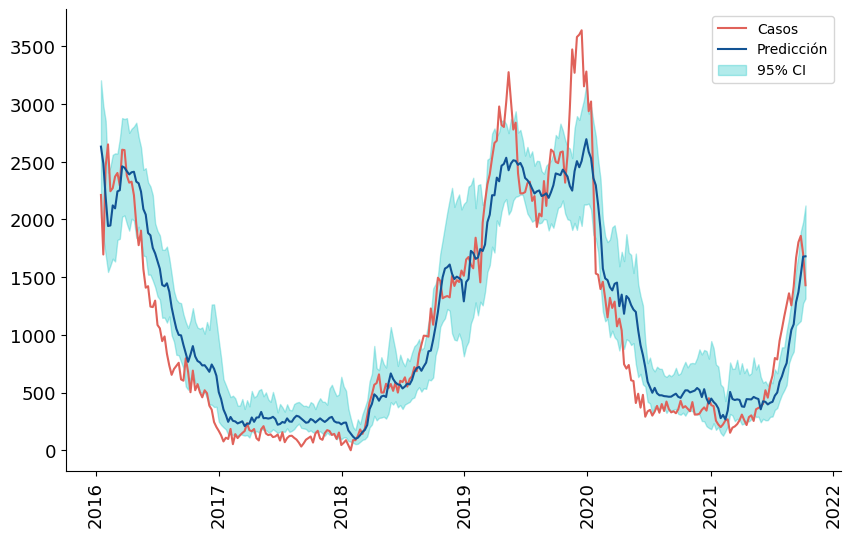

0.07702076743446208


In [18]:
results = create_df_response(np.array(predictions)[:,:,0,0], i.shape[0],
                             date_init = test_target.index[1])
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(results.index.values, test_y[:, 0]*dataset['Dengue'].max(), 
        label='Casos', color = "#E0625A")
ax.plot(results.index.values, results['median']*dataset['Dengue'].max(),
        label='Predicción', color = "#125394")
ax.fill_between(results.index.values, results["high_95"]*dataset['Dengue'].max(),
                results["low_95"]*dataset['Dengue'].max(), color='c', alpha=0.3,
                label='95% CI')

ax.tick_params( which='both', axis='x', labelrotation=90, labelsize=13)
ax.tick_params( which='both', axis='y', labelsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(fontsize=20)

# plt.title(rmse)
plt.legend()
plt.show()
print(rmse)

In [19]:
# Save the model
model.save_weights('../Models/model_weights770.h5')

In [ ]:
dptos = {
    5:'Antioquia',
    8:'Atlantico',
    11:'Bogotá',
    13:'Bolivar',
    15:'Boyacá',
    17:'Caldas',
    18:'Caquetá',
    19:'Cauca',
    20:'Cesar',
    23:'Cordoba',
    25:'Cundinamarca',
    27:'Chocó',
    41:'Huila',
    44:'La Guajira',
    47:'Magdalena',
    50:'Meta',
    52:'Nariño',
    54:'Norte de Santander',
    63:'Quindio',
    66:'Risaralda',
    68:'Santander',
    70:'Sucre',
    73:'Tolima',
    76:'Valle del Cauca',
    81:'Arauca',
    85:'Casanare',
    86:'Putumayo',
    88:'San Andrés y Providencia',
    91:'Amazonas',
    94:'Guainia',
    95:'Guaviare',
    97:'Vaupes',
    99:'Vichada'
}

In [2]:
dataset = pd.read_csv("../Data/finaldata_dptos.csv", parse_dates=['Date'])#, index_col=['Date', 'Dpto'])
dataset['Dpto'] = pd.to_numeric(dataset['Dpto']).astype(np.float32())
dataset = dataset.set_index(['Date', 'Dpto'])
print(dataset.shape)
dataset.head()

(25806, 7)


Dengue  Dengue_grave  Mortalidad_por_dengue  max_temperature  \
Date       Dpto                                                                 
2007-01-07 5.0      0.5           0.5                    0.0            37.85   
           8.0     36.5           2.5                    0.0            38.79   
           11.0     0.0           0.0                    0.0            33.11   
           13.0     2.5           1.0                    0.0            40.09   
           15.0     1.5           0.5                    0.0            38.01   

                 mean_temperature  min_temperature  mean_rain  
Date       Dpto                                                
2007-01-07 5.0          26.188997             4.69  20.050209  
           8.0          32.648692            25.27   0.636768  
           11.0         21.290053             7.75   2.755865  
           13.0         30.012799            14.59   4.231951  
           15.0         25.215505             4.77   6.990380

In [7]:
unique_departments = dataset.index.get_level_values('Dpto')

dataset1 = []
for d in unique_departments:
    # Scaling and normalizing data.
    scaler      = MinMaxScaler()
    subset = dataset.loc[dataset.index.get_level_values('Dpto') == d]
    data_scaled = scaler.fit_transform(subset)
    dataset1.append(pd.DataFrame(data_scaled, index = subset.index,
                        columns = subset.columns))
dataset1 = pd.concat(dataset1).sort_index()
dataset1

KeyboardInterrupt: 

In [ ]:
lag = 2

def shift_group(group):
    group.iloc[:, 2:] = group.iloc[:, 2:].shift(lag)
    return group

lagged_data = dataset1.reset_index().groupby('Dpto').apply(shift_group)

def index_and_trim(group):
    return group.iloc[:-lag]

lagged_data = lagged_data.reset_index().groupby('Dpto').apply(index_and_trim).reset_index(drop=True).dropna()
lagged_data = lagged_data.set_index(['Date', 'Dpto'])

def index_and_trim(group):
    return group.iloc[lag:-lag]

selected_columns = ['mean_temperature', 'min_temperature', 'max_temperature',
                    'mean_rain']
actual_data = dataset1[selected_columns]
actual_data = actual_data.reset_index().groupby('Dpto').apply(index_and_trim).reset_index(drop=True)
actual_data = actual_data.set_index(['Date', 'Dpto'])

target = dataset1['Dengue']
target = target.reset_index().groupby('Dpto').apply(index_and_trim).reset_index(drop=True)
# target = target.set_index(['Date', 'Dpto'])
# Join current and lagged data.
data = lagged_data.merge(actual_data, left_index=True, right_index=True).drop(columns='index').reset_index()

In [ ]:
# Split data for training, validation and test.
def index_and_trim(group):
    return group.iloc[:8*52]

train_data = data.groupby('Dpto').apply(index_and_trim).reset_index(drop=True)
train_target = target.groupby('Dpto').apply(index_and_trim).reset_index(drop=True)
train_data = pd.concat([train_data[train_data['Dpto'] == department] for department in unique_departments]).set_index('Date')
train_target = pd.concat([train_target[train_target['Dpto'] == department] for department in unique_departments]).set_index('Date')

def index_and_trim(group):
    return group.iloc[8*52:9*52]

val_data   = data.groupby('Dpto').apply(index_and_trim).reset_index(drop=True)
val_target = target.groupby('Dpto').apply(index_and_trim).reset_index(drop=True)
val_data = pd.concat([val_data[val_data['Dpto'] == department] for department in unique_departments]).set_index('Date')
val_target = pd.concat([val_target[val_target['Dpto'] == department] for department in unique_departments]).set_index('Date')

def index_and_trim(group):
    return group.iloc[9*52:]

test_data   = data.groupby('Dpto').apply(index_and_trim).reset_index(drop=True)
test_target = target.groupby('Dpto').apply(index_and_trim).reset_index(drop=True)
test_data = pd.concat([test_data[test_data['Dpto'] == department] for department in unique_departments]).set_index('Date')
test_target = pd.concat([test_target[test_target['Dpto'] == department] for department in unique_departments]).set_index('Date')

print(train_data.shape, train_target.shape, val_data.shape, val_target.shape, test_data.shape, test_target.shape)

In [ ]:
# Calculate the variance of the test data in each of the weeks of the year for each department.
new_test = test_data
df = pd.concat([new_test[new_test['Dpto'] == department] for department in unique_departments])
df_var  = df.groupby(['Dpto', new_test.index.week]).var().dropna()
df_mean = new_test

# Create new data to test the model for each department.
new_dfs = []

for _ in range(100):
    department_dfs = []
    for department, group in df_mean.groupby('Dpto'):
        values = []
        df_department_var = df_var.loc[department]

        for index, row in group.iterrows():
            mean_values = row.values[1:]
            week = index.week
            # Ignore week 53 and use until week 52 of the year.
            if week != 53:
                var_values = df_department_var.loc[week].values
            else:
                var_values = df_department_var.loc[week-1].values

            values.append([row.values[0]] + list(np.random.normal(mean_values, np.sqrt(var_values))))

        new_df = pd.DataFrame(np.array(values), columns=df_mean.columns, index=group.index)
        department_dfs.append(new_df)

    department_df = pd.concat(department_dfs).reset_index()
    new_dfs.append(pd.concat([department_df[department_df['Dpto'] == department] for department in unique_departments]).set_index('Date'))

In [ ]:
# Define the time steps for the encoder and decoder input and output.
n_steps_in  = 8
n_steps_out = 1

# Create the input sequences function.
def create_sequences(encoder_data, decoder_data, target_data, n_steps_in,
                     n_steps_out):
    X_encoder, X_decoder, y = [], [], []

    for i in range(n_steps_in, len(encoder_data) - n_steps_out):
        encoder_seq = encoder_data[i - n_steps_in:i, :]
        decoder_seq = decoder_data[i:i + n_steps_out, :]
        target_seq  = target_data[i:i + n_steps_out,1]

        X_encoder.append(encoder_seq)
        X_decoder.append(decoder_seq)
        y.append(target_seq)

    return np.array(X_encoder), np.array(X_decoder), np.array(y)

train_dpto = []
val_dpto = []
test_dpto = []
for j in unique_departments:
    X_train_encoder, X_train_decoder, train_y = create_sequences(train_data[train_data['Dpto']==j].values,
                                                                train_data[train_data['Dpto']==j].values,
                                                                train_target[train_target['Dpto']==j].values,
                                                                n_steps_in,
                                                                n_steps_out)
    X_val_encoder, X_val_decoder, val_y = create_sequences(val_data[val_data['Dpto']==j].values,
                                                        val_data[val_data['Dpto']==j].values,
                                                        val_target[val_target['Dpto']==j].values,
                                                        n_steps_in, n_steps_out)
    X_test_encoder, X_test_decoder, test_y = create_sequences(test_data[test_data['Dpto']==j].values,
                                                            test_data[test_data['Dpto']==j].values,
                                                            test_target[test_target['Dpto']==j].values,
                                                            n_steps_in,
                                                            n_steps_out)
    train_dpto.append([X_train_encoder, X_train_decoder, train_y])
    val_dpto.append([X_val_encoder, X_val_decoder, val_y])
    test_dpto.append([X_test_encoder, X_test_decoder, test_y])

In [ ]:
train_dpto_X_encoder = np.concatenate([seq[0] for seq in train_dpto], axis=0)
train_dpto_X_decoder = np.concatenate([seq[1] for seq in train_dpto], axis=0)
train_dpto_y = np.concatenate([seq[2] for seq in train_dpto], axis=0)

val_dpto_X_encoder = np.concatenate([seq[0] for seq in val_dpto], axis=0)
val_dpto_X_decoder = np.concatenate([seq[1] for seq in val_dpto], axis=0)
val_dpto_y = np.concatenate([seq[2] for seq in val_dpto], axis=0)

test_dpto_X_encoder = np.concatenate([seq[0] for seq in test_dpto], axis=0)
test_dpto_X_decoder = np.concatenate([seq[1] for seq in test_dpto], axis=0)
test_dpto_y = np.concatenate([seq[2] for seq in test_dpto], axis=0)

print(train_dpto_X_encoder.shape, train_dpto_X_decoder.shape, train_dpto_y.shape,
      val_dpto_X_encoder.shape, val_dpto_X_decoder.shape, val_dpto_y.shape,
      test_dpto_X_encoder.shape, test_dpto_X_decoder.shape, test_dpto_y.shape)

In [ ]:
# Create the sequences for the multiples test.
tests_data = []

for d in new_dfs:
    test_dpto1 = []
    for j in unique_departments:
        X_test_encoder1, test_data1, test_y1 = create_sequences(test_data[test_data['Dpto']==j].values,
                                                            d[d['Dpto']==j].values,
                                                            test_target[test_target['Dpto']==j].values,
                                                            n_steps_in,
                                                            n_steps_out)
        test_dpto1.append((X_test_encoder1, test_data1, test_y1))
    tests_data.append(np.concatenate([seq[1] for seq in test_dpto1], axis=0))

In [ ]:
# Define the number of features
n_features_encoder = 12
n_features_decoder = 12

# Create the model
encoder_inputs                    = Input(shape=(n_steps_in,
                                                 n_features_encoder))
encoder_lstm                      = LSTM(100, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

decoder_inputs        = Input(shape=(n_steps_out, n_features_decoder))
decoder_lstm          = LSTM(100, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=[state_h, state_c])

output = Dense(1, activation = 'sigmoid')(decoder_outputs)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0001)

model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='mean_absolute_error', metrics=['mae'])
# Fit the mmodel
model.fit([train_dpto_X_encoder, train_dpto_X_decoder], train_dpto_y,
          validation_data=([val_dpto_X_encoder, val_dpto_X_decoder], val_dpto_y),
          epochs=100,
          batch_size=2,
          shuffle=True)#,
        #   callbacks=[reduce_lr])

In [ ]:
# Test the model
predictions = []
for t in tests_data:
    predictions.append(model.predict([test_dpto_X_encoder, t], verbose=0))
predictions.append(model.predict([test_dpto_X_encoder, test_dpto_X_decoder]))

RMSE = []
for i in predictions:
    RMSE.append(np.sqrt(mean_squared_error(i.reshape(-1), test_dpto_y.reshape(-1))))
rmse = np.median(np.array(RMSE))
print("RMSE:", rmse)

In [ ]:
rmse_dpto = []
for k in range(33):
    RMSE = []
    for i in predictions:
        RMSE.append(np.sqrt(mean_squared_error(i.reshape(-1)[(k*301):((k+1)*301)], test_dpto_y.reshape(-1)[(k*301):((k+1)*301)])))
    rmse = np.mean(np.array(RMSE))
    rmse_dpto.append(rmse)
pd.DataFrame(rmse_dpto, dptos.values())

In [ ]:
results = []
for k in range(33):
    results.append(create_df_response(np.array(predictions)[:,(k*301):((k+1)*301),0,0], i.shape[0]/33,
                             date_init = test_target.index[0]))
results[0]

In [ ]:
for k in range(33):
    dmax = dataset.loc[dataset.index.get_level_values('Dpto') == unique_departments[k]]['Dengue'].max()
    # Plot results[k]
    plt.figure(figsize=(10, 6))
    plt.plot(results[k].index.values, test_dpto_y[(k*301):((k+1)*301),0]*dmax, label='Casos', color = "#E0625A")
    plt.plot(results[k].index.values, results[k]['median']*dmax, label='Predicción', color = "#125394")
    plt.fill_between(results[k].index.values, results[k]["high_95"]*dmax, results[k]["low_95"]*dmax, color='c', alpha=0.3, label='95%')
    # plt.fill_between(results[k].index.values, results[k]["high_50"]*dmax, results[k]["low_50"]*dmax, color='b', alpha=0.3, label='50% CI')

    plt.title((dptos[unique_departments[k]],rmse_dpto[k]))
    plt.legend()
    plt.show()